In [42]:
#!/usr/bin/python
# -*- coding:utf-8 -*-
'''
Created on 2019/01/02

@author: xidaowen
'''

import ntf
from myutil.histogram import createHistogram
from myutil.plotter import showFactorValue, showHistDistribution
from myutil.ponpare.reader import readPonpareData
from myutil.ponpare.converter import     digitizeHistoryFeatureValue, transformForHistogram
import multiview.mvtsne as mvtsne
from sklearn.utils.testing import assert_raises


import scipy
import numpy as np
import pandas as pd
from scipy import stats
# from scipy.special import entr
from scipy import spatial

import sys
import json
# from pyspark import SparkConf, SparkContext
import itertools

import logging
logging.basicConfig(level=logging.INFO)
_log = logging.getLogger('JNTF')


def showLabel(label):
    for i1, lbl1 in enumerate(label):
        print("label:[%d] ->" % i1)
        for lbl2 in lbl1:
            print(lbl2 + ",")
        print("")


class iFacData():
    def __init__(self):
        self.domain = ""
        self.labels = []
        self.base = 0
        self.cur_base = 0
        self.hist = None
        
    def readData(self, domain = "nba", columns = []):
        """
        read in the data and create labels
        """
        self.domain = domain
        if self.domain == "nba":
            shots = pd.read_csv("data/NBA_shots_201415.csv")
            shots = shots[['PLAYER_ID','PLAYER_NAME','TEAM_ID','TEAM_NAME','ZoneName','PERIOD','SHOT_ATTEMPTED_FLAG','SHOT_MADE_FLAG']]
            shots.PERIOD[shots.PERIOD > 4] = 5
            self.column = ['PERIOD','TEAM_NAME','ZoneName']
            shots_group_data_attempted = shots.groupby(self.column)['SHOT_ATTEMPTED_FLAG'].sum()
            shots_group_data_attempted1 = shots_group_data_attempted.unstack(fill_value=0).to_panel()
            self.hist = shots_group_data_attempted1.fillna(0).values
            for i in range(len(self.column)):
                each_label = shots_group_data_attempted1.fillna(0).axes[i].tolist()
                each_label = [str(each_one).replace('!', '').replace('(','').replace(')','').replace(' ','') for each_one in each_label]
                self.labels.append(each_label)
            
        if self.domain == "nbaplayer":
            top_cnt = 15
            shots = pd.read_csv("data/NBA_shots_201415.csv")
            shots = shots[['PLAYER_ID','PLAYER_NAME','TEAM_ID','TEAM_NAME','ZoneName','PERIOD','SHOT_ATTEMPTED_FLAG','SHOT_MADE_FLAG']]
            shots.PERIOD[shots.PERIOD > 4] = 5

            self.column = ['PERIOD','PLAYER_NAME','ZoneName']

            shots_total = shots.groupby(['PLAYER_NAME'])['SHOT_ATTEMPTED_FLAG'].sum()
            top_players = list(shots_total.sort_values(ascending=False).iloc[:top_cnt].index)

            shots = shots[shots.PLAYER_NAME.isin(top_players)]
            shots_group_data_attempted = shots.groupby(self.column)['SHOT_ATTEMPTED_FLAG'].sum()
            shots_group_data_made = shots.groupby(self.column)['SHOT_MADE_FLAG'].sum()
            shots_group_data_attempted = shots_group_data_made.div(shots_group_data_attempted, level=0)
            shots_group_data_attempted1 = shots_group_data_attempted.unstack(fill_value=0).to_panel()
            self.hist = shots_group_data_attempted1.fillna(0).values

            for i in range(len(self.column)):
                each_label = shots_group_data_attempted1.fillna(0).axes[i].tolist()
                each_label = [str(each_one).replace('!', '').replace('(','').replace(')','').replace(' ','') for each_one in each_label]
                self.labels.append(each_label)

        elif self.domain == "policy":
            policy = pd.read_csv("data/policy_adoption.csv")
            policy['adoption'] = 1
            policy = policy[policy.adopted_year >= 1970]
            policy = policy[policy.subject_name != "Unknown"]            
            self.column = ['subject_name', 'adopted_year', 'state_id']
            policy_group = policy.groupby(self.column)['adoption'].sum()
            policy_group1 = policy_group.unstack(fill_value=0).to_panel()
            self.hist = policy_group1.fillna(0).values
            for i in range(len(self.column)):
                each_label = policy_group1.fillna(0).axes[i].tolist()
                each_label = [str(each_one).replace('!', '').replace('(','').replace(')','').replace(' ','') for each_one in each_label]
                self.labels.append(each_label)            

        elif self.domain == "picso":
            policy = pd.read_csv("data/picso.csv", header=None)
            columns = ['member', 'year', 'keyword', 'value']
            policy.columns = columns
            self.column = columns[:3]
            policy_group = policy.groupby(self.column)['value'].sum()
            policy_group1 = policy_group.unstack(fill_value=0).to_panel()
            self.hist = policy_group1.fillna(0).values
            for i in range(len(self.column)):
                each_label = policy_group1.fillna(0).axes[i].tolist()
                each_label = [str(each_one) for each_one in each_label]
                self.labels.append(each_label)  
                
        elif self.domain == "purchase":
            couponAreaTest, couponAreaTrain, couponDetailTrain,                 couponListTest, couponListTrain,                 couponVisitTrain, userList = readPonpareData(valuePrefixed=True)

            # Convert to one-hot expression.
            userList, couponListTrain, couponListTest =                 digitizeHistoryFeatureValue(userList,
                                            couponListTrain,
                                            couponListTest)
            # Convert to histogram.
            distribution = transformForHistogram(userList,
                                                 couponDetailTrain,
                                                 couponVisitTrain,
                                                 couponListTrain,
                                                 couponListTest,
                                                 couponAreaTrain,
                                                 couponAreaTest)
            self.column = ["SEX_ID", "GENRE_NAME", "LIST_PREF_NAME","AGE"]
            self.hist, bins, label = createHistogram(distribution, self.column) 
            self.labels = [['00Male', '01Female'],
                           ['00Gourmet', '01Este', '02Beauty', '03NailEye', '04HairSalon', 
                            '05HealthMedicalCare', '06Relaxation', '07Leisure', '08HotelInn',
                            '09Lesson','10HomeDelivery','11GiftCard','12OtherCoupons'],
                      ['00北海道', '01青森県', '02岩手県', '03宮城県', '04秋田県', '05山形県', '06福島県', '07茨城県', '08栃木県', '09群馬県', '10埼玉県', '11千葉県', 
                      '12東京都', '13神奈川県', '14新潟県', '15富山県', '16石川県', '17福井県', '18山梨県', '19長野県', '20岐阜県', '21静岡県', '22愛知県', '23三重県', 
                      '24滋賀県', '25京都府', '26大阪府', '27兵庫県', '28奈良県', '29和歌山県', '30鳥取県', '31島根県', '32岡山県', '33広島県', '34山口県', '35徳島県', 
                      '36香川県', '37愛媛県', '38高知県', '39福岡県', '40佐賀県', '41長崎県', '42熊本県', '43大分県', '44宮崎県', '45鹿児島県', '46沖縄県'],
                      ['00under', '01-20', '02-25', '03-30', '04-35', '05-40', '06-45', '07-50', '08-55', '09-60', '10-65', '11-70', '12-75over'],
                      ['00under', '01-100', '02-1000', '03-2000', '04-3000', '05-5000', '06-10000', '07-20000', '08-30000', '09-50000over"']
    
                     ]            

    def computeReconstructionError(self, ntfInstance, hist):    
        """
        compute the reconstruction error
        type ntfInstance: NTF:
        type hist: np.array: tensor data
        rtype error: float
        """
        dstHist = ntfInstance.reconstruct()
        srcHist = hist
        diffHist = srcHist - dstHist
        diffHistSum = np.sum(diffHist*diffHist)
        srcHistSum = np.sum(srcHist*srcHist)
        return diffHistSum/srcHistSum

    def computeFit(self, ntfInstance, hist):
        dstHist = ntfInstance.reconstruct()
        mean_hist = np.full(hist.shape, np.mean(hist))
        mean_hist_diff = (mean_hist - hist)
        residual_hist = dstHist - hist
        ss_total = np.sum(mean_hist_diff*mean_hist_diff)        
        ss_res = np.sum(residual_hist*residual_hist)        
        return 1 - ss_res*1. / ss_total




    def getFitForRanks(self, bases, trials = 5):
        """
        compute the factors given different ranks and different random initializations
        type bases: int: max number of components
        type trials: int: number of independent trials
        """

        def pctnonzero(arr):
            return (len(arr) - np.count_nonzero(arr))*1./len(arr)

        def gini(arr):
            # (Warning: This is a concise implementation, but it is O(n**2)
            # in time and memory, where n = len(x).  *Don't* pass in huge
            # samples!)
            # Mean absolute difference
            mad = np.abs(np.subtract.outer(arr, arr)).mean()
            # Relative mean absolute difference
            rmad = mad/np.mean(arr)
            # Gini coefficient
            g = 0.5 * rmad
            return g        

        def normalized_entropy(arr):            
            return stats.entropy(arr) *1. / np.log(len(arr))

        def theil(arr): 
            # natural logarithm is default
            redundancy = np.log(len(arr)) - stats.entropy(arr)
            # inequality = 1 - exp(-redundancy)
            return redundancy



        self.base = bases
        self.trials = trials
        self.all_trials = []
        self.metrics = {"error":[None]*self.base, 
                        "fit":[None]*self.base, 
                        "stability": [None]*self.base, 
                        "entropy": [None]*self.base, 
                        "normalized_entropy": [None]*self.base, 
                        "pctnonzeros": [None]*self.base, 
                        "gini": [None]*self.base, 
                        "theil": [None]*self.base, 
                        "min_error_index": [None]*self.base}
        
        self.weights_all = [None]*self.base
        self.factors_all = [None]*self.base

        conf = SparkConf().set("spark.driver.maxResultSize", "220g").setAppName("DSGD_NTF")
        self.sc = SparkContext(conf=conf)
        # def getNTF(random_seed, base_cnt, hist):
        #   ntfInstance = ntf.NTF(base_cnt, hist, parallelCalc=True, ones = False, random_seed = random_seed)
        #   ntfInstance.factorize(hist, showProgress=True)
        #   # print(ntfInstance.factor)
        #   return ntfInstance

        # self.start_index = 2
        for self.base_cnt in range(self.start_index, self.base+1):
            try:
                _log.info("Current Rank: {}".format(self.base_cnt))
                each_rank_trials = []
                for random_seed in range(self.trials):
                    _log.info("Current Trial: {}".format(random_seed))
                    ntfInstance = ntf.NTF(self.base_cnt, self.hist, parallelCalc=True, ones = False, random_seed = random_seed)
                    ntfInstance.factorize(self.hist, showProgress=True)
                    each_rank_trials.append(ntfInstance)

                self.all_trials.append(each_rank_trials)
                _log.info("Getting Metric for rank: {}".format(self.base_cnt))
                self.metrics["error"][self.base_cnt-self.start_index] = []
                self.metrics["fit"][self.base_cnt-self.start_index] = []
                self.metrics["stability"][self.base_cnt-self.start_index] = []
                self.metrics["entropy"][self.base_cnt-self.start_index] = []            
                self.metrics["normalized_entropy"][self.base_cnt-self.start_index] = []
                self.metrics["gini"][self.base_cnt-self.start_index] = []            
                self.metrics["theil"][self.base_cnt-self.start_index] = []            
                self.metrics["pctnonzeros"][self.base_cnt-self.start_index] = []
                self.weights_all[self.base_cnt-self.start_index] = []
                self.factors_all[self.base_cnt-self.start_index] = []            
                for random_seed in range(self.trials):
                    _log.info("Getting Metric for Trial: {}".format(random_seed))               
                    ntfInstance = self.all_trials[self.base_cnt-self.start_index][random_seed]            
                    self.metrics["error"][self.base_cnt-self.start_index].append(self.computeReconstructionError(ntfInstance,self.hist))
                    self.metrics["fit"][self.base_cnt-self.start_index].append(self.computeFit(ntfInstance,self.hist))
                    weights, factors = ntfInstance.getNormalizedFactor()
                    self.weights_all[self.base_cnt-self.start_index].append(weights)
                    self.factors_all[self.base_cnt-self.start_index].append(factors)
                    self.metrics["entropy"][self.base_cnt-self.start_index].append(np.mean([stats.entropy(factors[i][j]) for i in range(len(factors)) for j in range(len(factors[0]))]))
                    self.metrics["normalized_entropy"][self.base_cnt-self.start_index].append(np.mean([normalized_entropy(factors[i][j]) for i in range(len(factors)) for j in range(len(factors[0]))]))                
                    self.metrics["pctnonzeros"][self.base_cnt-self.start_index].append(np.mean([pctnonzero(factors[i][j]) for i in range(len(factors)) for j in range(len(factors[0]))]))
                    self.metrics["theil"][self.base_cnt-self.start_index].append(np.mean([theil(factors[i][j]) for i in range(len(factors)) for j in range(len(factors[0]))]))
                    self.metrics["gini"][self.base_cnt-self.start_index].append(np.mean([gini(factors[i][j]) for i in range(len(factors)) for j in range(len(factors[0]))]))
                    

                best_fit_index = np.argmin(self.metrics["error"][self.base_cnt-self.start_index])
                self.metrics["min_error_index"][self.base_cnt-self.start_index] = int(best_fit_index)
                self.best_factors = self.factors_all[self.base_cnt-self.start_index][best_fit_index]
                self.best_weights = self.weights_all[self.base_cnt-self.start_index][best_fit_index]
                for random_seed in range(self.trials):
                    _log.info("Getting Similarity for Trial: {}".format(random_seed))               
                    self.cur_factors = self.factors_all[self.base_cnt-self.start_index][random_seed]
                    self.cur_weights = self.weights_all[self.base_cnt-self.start_index][random_seed]
                    self.metrics["stability"][self.base_cnt-self.start_index].append(self.maxFactorSimilarity(self.cur_factors, self.cur_weights, self.best_factors, self.best_weights, self.base_cnt))   
                self.cur_base = self.base_cnt                 
                self.saveAttributes()
            except:
                # raise
                continue
                    

    def maxFactorSimilarity(self, cur_factors, cur_weights, best_factors, best_weights, base_cnt):
        """
        compute the max similarity to a given set of factors by permutations
        based on equ.12 https://www.biorxiv.org/content/biorxiv/early/2017/10/30/211128.full.pdf
        type cur_factors: array: the factors resulted from different runs
        type cur_weights: array: the weights resulted from different runs
        type best_factors: array: the factors with best fit
        type best_weights: array: the weights with best fit
        type base_cnt: int: the rank
        rtype similarity: float: best similarity
        """
        # from pprint import pprint
        # import itertools
        num_sample = 1000
        # permuts = self.sc.parallelize(list(itertools.permutations(range(base_cnt)))).takeSample(False, num_sample, seed = 1)
        random_seed = self.sc.parallelize(list(range(num_sample)))
        


        def computeEachSimilarity(each_seed, cur_factors, cur_weights, best_factors, best_weights):
            each_permutation = list(np.random.RandomState(seed=each_seed).permutation(len(best_factors)))
            # return np.mean([stats.spearmanr(cur_factors[list(each_permutation)[i]][j], best_factors[i][j])[0] for i in range(len(best_factors)) for j in range(len(best_factors[0]))])
            similarity = 0.
            for component_index in range(len(best_factors)):
                rst = 1. - (abs(best_weights[component_index] - cur_weights[each_permutation[component_index]])) / max(best_weights[component_index], cur_weights[each_permutation[component_index]])
                for factor_index in range(len(best_factors[0])):
                    rst *= spatial.distance.cosine(cur_factors[each_permutation[component_index]][factor_index], best_factors[component_index][factor_index])
                similarity += rst
            similarity /= len(best_factors)

            return similarity
        
        all_permutation_similarity = random_seed.map(lambda each_seed: computeEachSimilarity(each_seed, cur_factors, cur_weights, best_factors, best_weights)).collect()
        similarity = max(all_permutation_similarity)
        return similarity
        
            
    def factorizeTensor(self, ones = True, random_seed = 1):
        """
        factorize the tensor
        type ones: boolean: whether use all ones as initialization
        type random_seed: int: the random seed if not using ones
        """
        
        print("Start factorization...")
        self.ntfInstance = ntf.NTF(self.cur_base, self.hist, parallelCalc=True, ones = ones, random_seed = random_seed)
        self.ntfInstance.factorize(self.hist, showProgress=True)
        self.ntfInstance.normalizeFactor()        

        
    def normalizeFactor(self):
        """
        normalize the weights
        """        
        self.ntfInstance.normalizedWeight = self.ntfInstance.weight / np.sum(self.ntfInstance.weight)            
    
    def getFactors(self):
        """
        obtain the factors
        """        
        
        self.factors = self.ntfInstance.factor
#         self.column = ['ZONE','PERIOD', 'TEAM']
        self.data = [np.array([self.factors[i][j].tolist() for i in range(len(self.factors))]) for j in range(len(self.column))]
        

    def computeItemSimilarity(self):
        """
        compute the pairwise item similarity
        """
        import math
        self.itemSimilarity = {}
        for k in range(len(self.data)):
            self.itemSimilarity[k] = {}
            for i in range(len(self.data[k].T)):
                self.itemSimilarity[k][self.labels[k][i]] = {}
                for j in range(len(self.data[k].T)):
                    if i == j:
                        continue
                    dataSetI = self.data[k].T[i]
                    dataSetII = self.data[k].T[j]
                    # import pdb
                    # pdb.set_trace()
                    result = scipy.stats.spearmanr(dataSetI.T, dataSetII.T)
                    # print(result)
                    if not math.isnan(result.correlation):
                        self.itemSimilarity[k][self.labels[k][i]][self.labels[k][j]] = result.correlation
                    else:
                        self.itemSimilarity[k][self.labels[k][i]][self.labels[k][j]] = 0

                max_item = self.itemSimilarity[k][self.labels[k][i]][max(self.itemSimilarity[k][self.labels[k][i]], 
                                                                         key=self.itemSimilarity[k][self.labels[k][i]].get)]
                min_item = self.itemSimilarity[k][self.labels[k][i]][min(self.itemSimilarity[k][self.labels[k][i]], 
                                                                         key=self.itemSimilarity[k][self.labels[k][i]].get)]
                # normalize
                if max_item != min_item:
                    for j in self.itemSimilarity[k][self.labels[k][i]]:
                        self.itemSimilarity[k][self.labels[k][i]][j] = (self.itemSimilarity[k][self.labels[k][i]][j] - min_item) / (max_item - min_item)

    def computeEntropy(self):
        """
        compute the entropy of each descriptor
        """
        self.entropies = []
        for j in range(len(self.factors[0])):
            self.entropies.append([stats.entropy(self.factors[i][j]) for i in range(len(self.factors))])
        self.max_entropy = np.max(self.entropies, axis = 1).tolist()
        self.min_entropy = np.min(self.entropies, axis = 1).tolist()

    def getMaxPatternForItem(self):
        """
        compute the most relevant pattern for each item
        """
        ## Get max pattern of each item
        self.item_max_pattern = {}
        for i in range(len(self.factors[0])):
            self.item_max_pattern[i] = {}
            for j in range(len(self.labels[i])):        
                item_list_label = [self.factors[m][i][j] for m in range(len(self.factors))]        
                self.item_max_pattern[i][self.labels[i][j]] = max(enumerate(item_list_label),key=lambda x: x[1])[0]
        
    def getMeanDistribution(self):
        """
        compute the mean distribution of each descriptor
        """
        data_mean = [np.mean([self.factors[i][j].tolist() for i in range(len(self.factors))],axis=0).tolist() for j in range(len(self.column))]
        self.data_mean_descriptor = []
        for m in range(len(data_mean)):
            each_dict_descriptor = dict(zip(self.labels[m], data_mean[m]))
            each_dict_descriptor['id'] = self.cur_base
            self.data_mean_descriptor.append(each_dict_descriptor)
        
    def getEmbedding(self, rd_state = 3):
        """
        use multiview tsne to embed the components to 2d plane
        type rd_state: int: random state
        """
        self.rd_state = rd_state
        is_distance = [False] * len(self.data)
        mvtsne_est = mvtsne.MvtSNE(k=2, perplexity = 10,random_state = self.rd_state, epoch = 3000)
        mvtsne_est.fit(self.data, is_distance)
        self.X_embedded = np.asarray(mvtsne_est.embedding_)        
            
            
    def formatOutput(self):
        self.data_output = {"descriptors": dict(zip(self.column, self.labels)),
                            "average":self.data_mean_descriptor, 
                            "itemSimilarity":self.itemSimilarity,
                            # "metrics":self.metrics,
                            # "item_max_pattern": self.item_max_pattern,
                            "item_max_pattern": '',
                            "start_index":str(self.start_index),
                            "modes": self.column}                
        output = []
        for i in range(len(self.factors)):
            output_each = {}
            output_each['id'] = i
            output_each['factors'] = {}
            output_each['dims'] = len(self.factors[i])
            output_each['tsne_coord'] = {'x': self.X_embedded[i][0],'y':self.X_embedded[i][1]}
            output_each['weight'] = self.ntfInstance.normalizedWeight[i]
            output_each['max_tsne'] = np.max(self.X_embedded, axis = 0).tolist()
            output_each['min_tsne'] = np.min(self.X_embedded, axis = 0).tolist()
            for j in range(len(self.factors[i])):
                a = self.factors[i][j]
                output_each['factors'][j] = {}
                output_each_factor = {}
                output_each_factor['mode_id'] = j        
                _dict = dict((self.labels[j][m], a[m]) for m in range(len(a)))
                output_each_factor['max_item'] = max(_dict, key=_dict.get)
                output_each_factor['min_item'] = min(_dict, key=_dict.get)
                _dict['id'] = i
                output_each_factor['values'] = _dict
                output_each_factor['entropy'] = (self.entropies[j][i] - self.min_entropy[j]) / (self.max_entropy[j] - self.min_entropy[j])
                output_each_factor['similarity'] = {}
                for k in range(len(self.factors)):        
                    if k == i:
                        continue
                    dataSetII = self.factors[k][j]
                    dataSetI = self.factors[i][j]
                    result = scipy.stats.spearmanr(dataSetI, dataSetII)[0]
                    output_each_factor['similarity'][k] = result
                dict_ = output_each_factor['similarity']
                max_item = dict_[max(dict_, key=dict_.get)]
                min_item = dict_[min(dict_, key=dict_.get)]
                if max_item != min_item:
                    for k in dict_:
                        dict_[k] = (dict_[k] - min_item) / (max_item - min_item)
                output_each_factor['similarity'] = dict_
                output_each_factor['similarity']['average'] = sum(dict_.values())/len(dict_.values())  
                output_each_factor['similarity']['max_idx'] = max(dict_, key=dict_.get)
                output_each_factor['similarity']['min_idx'] = min(dict_, key=dict_.get)
                output_each_factor['similarity'][i] = 1.0
                output_each['factors'][j] = output_each_factor
            output.append(output_each)

        self.data_output["data"] = output        
            
    def saveOutput(self):
        
        with open('/home/xidao/project/thesis/iFac/src/src/data/'+self.domain+'/factors_'+str(len(self.column))+'_'+str(self.cur_base)+'_sample_fit.json', 'w') as fp:
            json.dump(self.data_output, fp)

        with open('/home/xidao/project/thesis/iFac/src/src/data/'+self.domain+'/factors_'+str(len(self.column))+'_'+str(self.cur_base)+'_sample_fit_metrics.json', 'w') as fp:
            json.dump(self.metrics, fp)         

    def saveAttributes(self):
        _log.info("Factorize Tensor")   
        self.factorizeTensor(ones = False, random_seed = iFac.metrics["min_error_index"][self.cur_base-self.start_index])
        _log.info("Get Factors")          
        self.normalizeFactor()
        self.getFactors()
        _log.info("Compute Item Similarity")                    
        self.computeItemSimilarity()
        self.computeEntropy()
        self.getMaxPatternForItem()
        self.getMeanDistribution()
        try:
            self.getEmbedding()
        except:
            _log.info("running embedding again...")
            self.rd_state += 1
            self.getEmbedding(rd_state = self.rd_state)
        _log.info("Saving Output")                              
        self.formatOutput()
        self.saveOutput()

    def readFactorJSON(self, base_cnt=10, domain = "", ndims = 3):
        self.base_cnt = base_cnt
        self.domain = domain
        self.ndims = ndims
        file = "../data/{}/factors_3_{}_sample_fit.json".format(self.domain,self.ndims, self.base_cnt)
        with open(file) as f:
            self.data_output = json.load(f)

    def readMetricJSON(self, base_cnt=10, domain = "", ndims = 3):
        self.base_cnt = base_cnt
        self.domain = domain
        self.ndims = ndims
        file = "../data/{}_bk/factors_{}_{}_sample_fit_metrics.json".format(self.domain, self.ndims, self.base_cnt)
        with open(file) as f:
            metrics = json.load(f)
        return metrics


    def reEmbed(self, rd_state = 4):
        self.getEmbedding(rd_state = rd_state)

        for i in range(component_cnt):          
            self.data_output['data'][i]['tsne_coord'] = {'x': self.X_embedded[i][0],'y':self.X_embedded[i][1]}
            self.data_output['data'][i]['max_tsne'] = np.max(self.X_embedded, axis = 0).tolist()
            self.data_output['data'][i]['min_tsne'] = np.min(self.X_embedded, axis = 0).tolist()

        self.cur_base = component_cnt
        self.column = self.data_output['modes']
        self.saveOutput()


def generateAll():
    iFac = iFacData()
    base = 30
    iFac.start_index = 2
    domain = "policy"   
    nb_trials = 5

    base = int(sys.argv[1])
    iFac.start_index = int(sys.argv[2])
    domain = str(sys.argv[3])

    iFac.readData(domain = domain)
    _log.info("Fitting Different Ranks up to {}".format(base))
    iFac.getFitForRanks(base, trials = nb_trials)

def aggregateAll(start_index, end_index, domain = "policy"):
    iFac = iFacData()
    base = 30
#     iFac.start_index = 2
#     domain = "policy"   

    iFac.start_index = start_index
    iFac.end_index = end_index
    domain = domain
    measures = ["error", "fit", "stability", "entropy", "normalized_entropy", "pctnonzeros", "gini", "theil", "min_error_index"]        
    start_metrics = iFac.readMetricJSON(base_cnt=iFac.start_index, domain = domain)
    for i in range(iFac.start_index+1, iFac.end_index+1):
        cur_metrics = iFac.readMetricJSON(base_cnt=i, domain = domain)
        for m in measures:
            cur_metrics[m] = [x for x in start_metrics[m] if x is not None] + [x for x in cur_metrics[m] if x is not None]        
        with open('/home/xidao/project/thesis/iFac/src/src/data/'+domain+'/factors_3_'+str(i)+'_sample_fit_metrics.json', 'w') as fp:
            json.dump(cur_metrics, fp)         

def generateEmbedding():
    return
    



# if __name__ == '__main__':
# #     generateAll()
#     aggregateAll()

In [14]:
# aggregateAll(40, 50)

In [121]:
iFac = iFacData()
base = 10
# iFac.start_index = 10
# iFac.end_index = 20
domain = "nbaplayer"   
iFac.readData(domain = domain)

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:84: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.



In [103]:
def getItemEmbedding(data, rd_state = 3):
    """
    use multiview tsne to embed the components to 2d plane
    type rd_state: int: random state
    """
    
    is_distance = [False] * 1
    mvtsne_est = mvtsne.MvtSNE(k=2, perplexity = 10,random_state = rd_state, epoch = 3000)
    mvtsne_est.fit([data], is_distance)
    X_embedded = np.asarray(mvtsne_est.embedding_)
    return X_embedded

In [122]:
iFac.cur_base = 5
iFac.factorizeTensor(ones = False, random_seed = 1)

Start factorization...
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
[20/100]
 None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
[40/100]
 None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
[60/100]
 None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
[80/100]
 None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
* None
[100/100]
 None


In [123]:
iFac.normalizeFactor()
iFac.getFactors()

In [124]:
embeddings = getItemEmbedding(iFac.data[0].T)

/home/xidao/project/thesis/iFac/src/src/engine/multiview/mvtsne.py:278: RuntimeWarning: divide by zero encountered in true_divide
  ((-2 * np.dot(ydata, ydata.T))[:, ] + sum_ydata[:]).T)


In [125]:
iFac.labels[2]

['AnthonyDavis',
 'ChrisPaul',
 'DamianLillard',
 'JamesHarden',
 'JohnWall',
 'KlayThompson',
 'KyrieIrving',
 'LaMarcusAldridge',
 'LeBronJames',
 'MontaEllis',
 'NikolaVucevic',
 'PauGasol',
 'RussellWestbrook',
 'StephenCurry',
 'TyrekeEvans']

In [126]:
embedding

array([[-2.31582051e+05,  1.40904085e+08],
       [-4.36616355e+06,  2.65650479e+09],
       [-4.36022007e+06,  2.65316766e+09],
       [ 2.20478814e+07, -1.34159156e+10],
       [-4.36560788e+06,  2.65518954e+09],
       [-4.36526423e+06,  2.65672842e+09],
       [-4.36429702e+06,  2.65525487e+09],
       [-4.36613482e+06,  2.65609143e+09],
       [-4.36334232e+06,  2.65600998e+09],
       [-4.35929877e+06,  2.65311312e+09],
       [-4.35931066e+06,  2.65401132e+09],
       [ 2.20471730e+07, -1.34159156e+10],
       [-2.31582319e+05,  1.40904095e+08],
       [-4.36225067e+06,  2.65395190e+09]])

In [95]:
from sklearn.manifold import TSNE
embeddings = TSNE(n_components=2, init='pca', verbose=2, perplexity= 20, random_state= 2).fit_transform(iFac.data[0].T)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 13 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 14 / 14
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Iteration 25: error = 1.8577605, gradient norm = 0.0030199
[t-SNE] Iteration 50: error = 1.7510022, gradient norm = 0.0026908
[t-SNE] Iteration 75: error = 1.4105489, gradient norm = 0.0018343
[t-SNE] Iteration 100: error = 1.3228570, gradient norm = 0.0016607
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.322857
[t-SNE] Iteration 125: error = 1.1656243, gradient norm = 0.0013839
[t-SNE] Iteration 150: error = 1.1143312, gradient norm = 0.0013017
[t-SNE] Iteration 175: error = 1.1013039, gradient norm = 0.0012814
[t-SNE] Iteration 200: error = 1.0977776, gradient norm = 0.0012760
[t-SNE] Iteration 225: error = 1.0968055, gradient norm = 0.0012745
[t-SNE] Iteration 250: error = 1.0965366, gradient norm = 0.0012741
[t-SNE] Iteration 275: error = 1.0964618, gradient norm = 

In [96]:
from sklearn.manifold import MDS
embeddings = MDS(n_components=2)
label_index = 2
embeddings = embeddings.fit_transform(iFac.data[label_index].T)

array([[  -28.97663886,  -230.0191033 ],
       [ -251.91947532,    -8.14492639],
       [  -11.68831068,   179.19349836],
       [  170.41079634,   231.5440651 ],
       [  896.86877416,   920.81226355],
       [  304.25544514,    23.2694574 ],
       [ -195.09040003,   183.08697365],
       [  -56.94180401,   -26.47995482],
       [ -630.06479546, -1319.4970888 ],
       [  117.48421304,    19.93860904],
       [ -814.94454734,  -740.56498016],
       [  707.63997015,  1340.60276891],
       [  155.47057897,  -175.63281336],
       [ -222.79189898,  -206.46679613]])

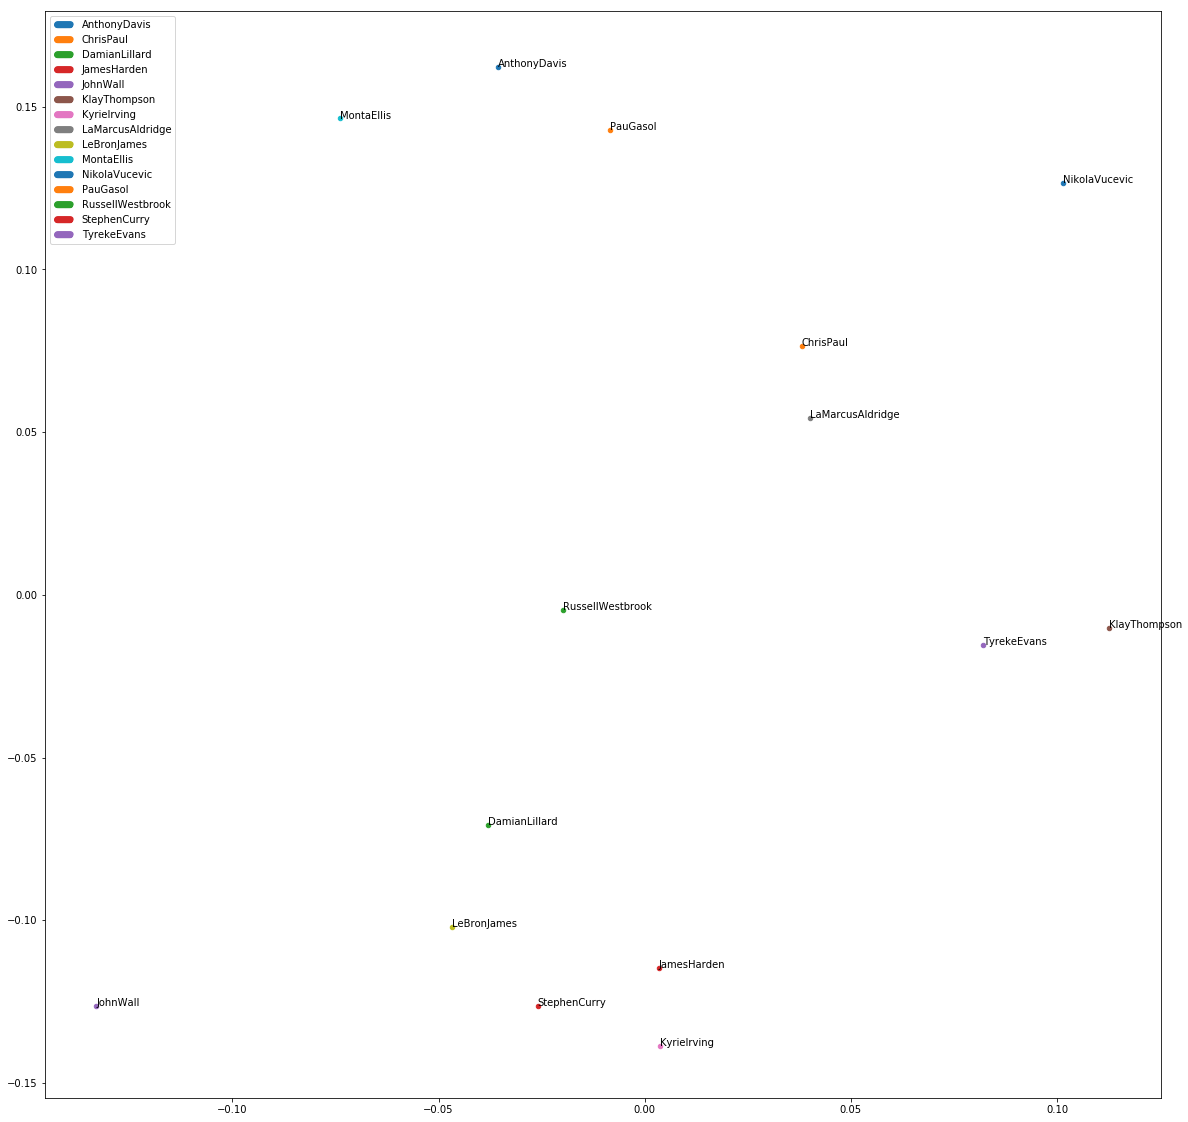

In [134]:
X_embedded_ = embeddings

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.mlab as mlab
from matplotlib.ticker import NullFormatter

fig = plt.figure()
ax = fig.add_subplot(111)

xx = X_embedded_[:, 0]
yy = X_embedded_[:, 1]

colors = ["blue","red"]
# labes = ["0","1"]
# plot the 2D data points
for i in range(len(iFac.labels[label_index])):    
    ax.scatter(xx[i], yy[i], label=iFac.labels[label_index][i], s=20)
    ax.annotate(iFac.labels[label_index][i], (xx[i], yy[i]))

# ax.xaxis.set_major_formatter(NullFormatter())
# ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')
plt.legend(loc='best', scatterpoints=50, fontsize=10)
plt.rcParams['figure.figsize'] = [20, 20]

plt.show()


In [41]:
test_metrics['entropy']

[[2.396882664913085,
  2.3995887415675807,
  2.39471412085592,
  2.3888495546254576,
  2.3838582928263317],
 [2.365725725380589,
  2.368459571540182,
  2.3686156901302047,
  2.360013822992312,
  2.3715420442638724],
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]